In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import os,re
from string import punctuation
import random
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split


def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
tf.config.list_physical_devices('GPU')

2024-12-02 11:04:26.439678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 11:04:26.455544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 11:04:26.460137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 11:04:26.471933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 11:04:27.281233: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def preprocess_text(x,tweet=False):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;//%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    x = x + ' '
    return re.sub(r'\s+', ' ', x).strip()

In [3]:
df = pd.read_csv('/home/bibek/dataset/train.csv')
df['cleaned_text'] = df.text.apply(lambda x: preprocess_text(x))

In [4]:
from custom_tokenizer import BytePairEncodingTokenizer
import json

# load and initialize tokenizer
tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')
tokenizer.maxlen = 128

# load roberta config
with open('roberta_config.json','r') as f:
    config = json.load(f)

# load pretrained weights
with open('roberta_weights.pkl','rb') as f:
    weights = pickle.load(f)

In [5]:
# tokenize sequences
seqs = [tokenizer.tokenize(x) for x in tqdm(df.cleaned_text)]
seqs = [tokenizer.add_padding(x) for x in seqs]
seqs = np.array(seqs,dtype=np.int16)

100%|█████████████████████████████████████| 7613/7613 [00:07<00:00, 1079.84it/s]


In [6]:
xtrain,xtest,ytrain,ytest = train_test_split(seqs,df.target,train_size=0.75,random_state=0)

In [7]:
from bert import BERT

maxlen = 128
batch = 8

roberta = BERT(**config)

reset_random_seeds()

i = tf.keras.layers.Input((maxlen,),batch_size=batch)
x = roberta(i)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

model.summary()

 

I0000 00:00:1733117676.599578    4662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733117676.599835    4662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733117676.599987    4662 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733117676.665780    4662 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (8, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert (BERT)                     │ (8, 128, 256)          │     6,737,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (8, 256)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (8, 1)                 │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,737,665 (25.70 MB)

 Trainable params: 6,737,665 (25.70 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# set pretrained weights
model.layers[1].set_weights(weights)

# freeze postional encoding weights
roberta.embedding.pos_emb_layer.trainable = False

In [9]:
@tf.function
def train_step(x,y,model):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y,model):
    pred = model(x,training=False)
    loss = loss_fn(y,pred)
    return loss

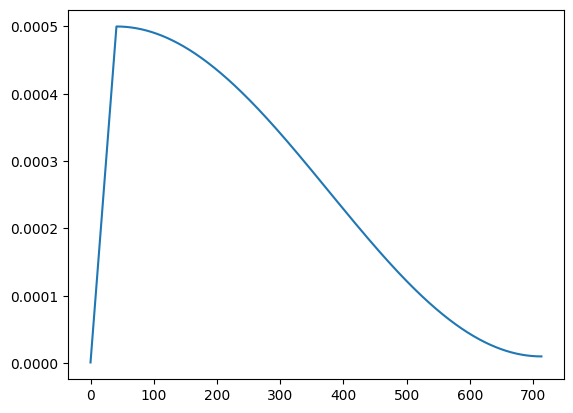

In [10]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01,beta_2=0.98,epsilon=1e-6)


class CosineLRScheduler:
    def __init__(self,total_steps,max_lr=5e-4,min_lr=1e-5,init_lr=1e-6):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.init_lr = init_lr
        self.total_setps = total_steps
        self.warmup = int(total_steps * 0.06)
        self.decay = total_steps - self.warmup
        self.warmup_lr = np.linspace(init_lr,max_lr,self.warmup)
        
        
    def __call__(self,step):
        
        if step <= self.warmup:
            
            lr = self.warmup_lr[step-1]
        else:   
            step = step - self.warmup
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(step * np.pi / self.decay))
        
        return lr



total_steps = len(xtrain) // batch + 1
    

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=batch).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=batch)
# test = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=batch)


# lr_decay = [cosine_lr_decay(s,total_setps=total_steps,max_lr=3e-4,min_lr=0) for s in range(1,total_steps+1)]

lr_scheduler = CosineLRScheduler(total_steps)

# lr_scheduler(152)
plt.plot([lr_scheduler(i) for i in range(1,total_steps+1)])


In [11]:
epochs = 3

losses = {'train':[],'valid':[]}
check = []
for e in range(1,epochs+1):
    
    print(f'EPOCH : {e}/{epochs}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,model)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    
    loss = 0
    for i,(x,y) in enumerate(valid):
        loss += test_step(x,y,model)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'roberta_weights.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'roberta_weights.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    print()

EPOCH : 1/3


100%|█████████████████████████████████████████| 714/714 [00:17<00:00, 40.51it/s]
2024-12-02 11:04:57.007809: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train_loss : 0.7439
val_loss : 0.5172
weights saved

EPOCH : 2/3


100%|█████████████████████████████████████████| 714/714 [00:09<00:00, 73.62it/s]
2024-12-02 11:05:07.460759: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train_loss : 0.4215
val_loss : 0.4325
weights saved

EPOCH : 3/3


100%|█████████████████████████████████████████| 714/714 [00:09<00:00, 73.44it/s]


train_loss : 0.3772
val_loss : 0.4948



In [12]:
model.load_weights('roberta_weights.weights.h5')

In [13]:
preds = []
for i,(x,y) in enumerate(valid):
    
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(ytest,preds))
print('f1_score :',f1_score(ytest.values,preds))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1107
           1       0.78      0.75      0.77       797

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904

f1_score : 0.7656050955414013


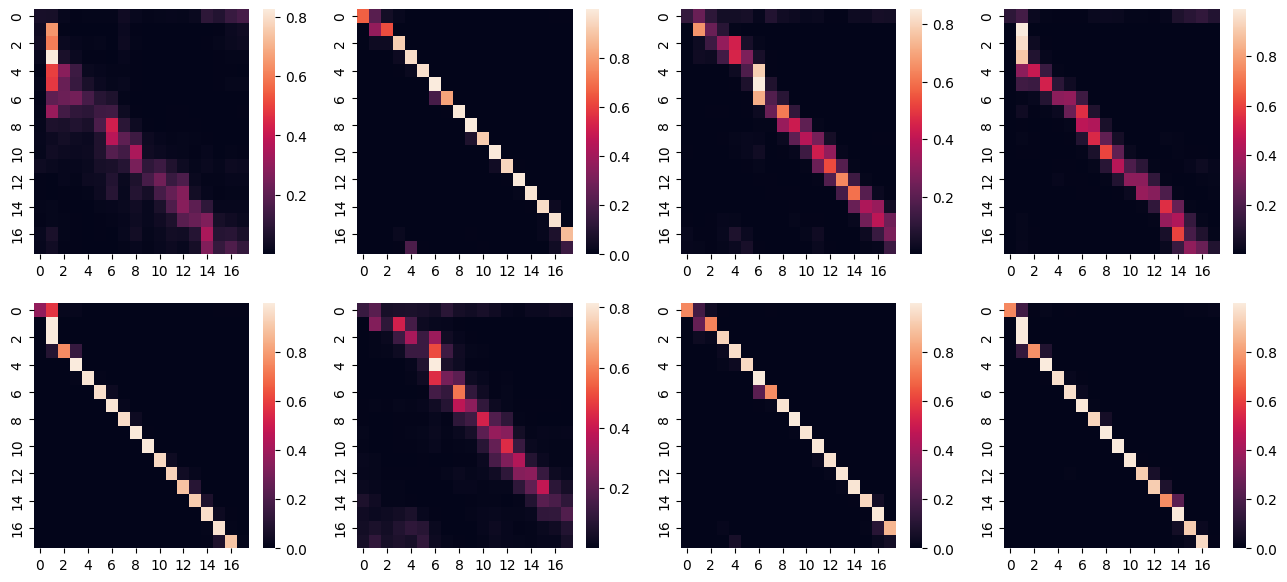

In [14]:
i = np.random.randint(0,len(xtest)-1)
x = xtest[i][np.newaxis,:]
model(x)


# layer 2 attention weights
idx = np.where(x[0]!=0)[0][-1]

attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

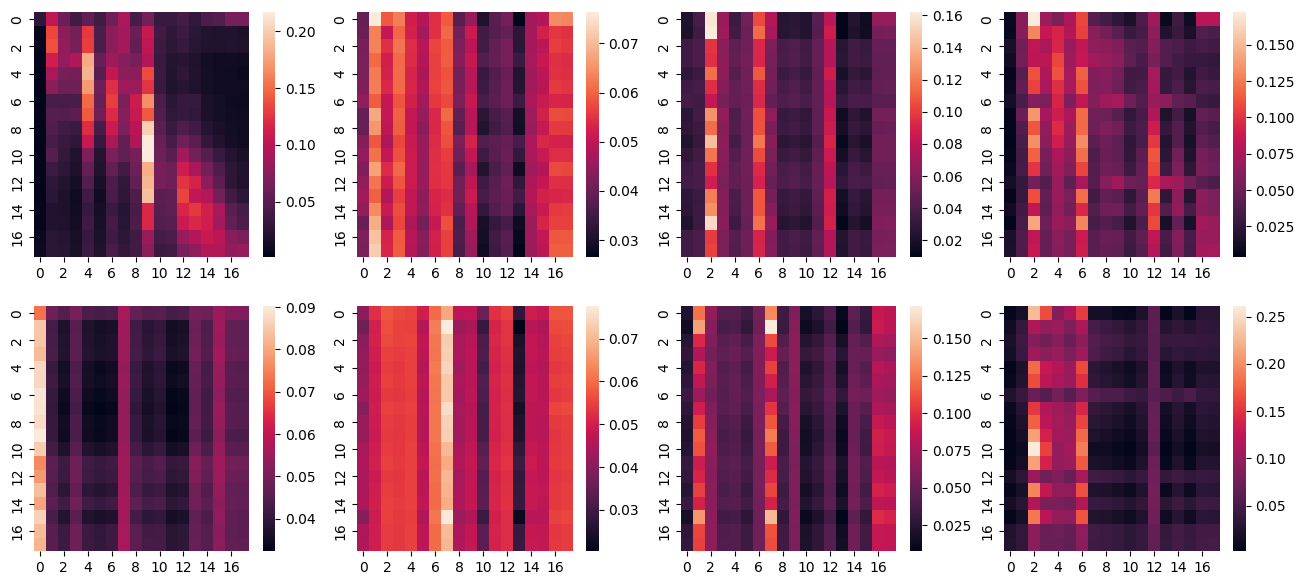

In [15]:
# layer 1 attention weights

attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()